In [51]:
# !pip install xgboost
# !pip install bayesian-optimizatio
# !pip install optuna
# !pip install --upgrade lightgbm
!pip install statsmodels


     |████████████████████████████████| 10.9 MB 16.4 MB/s eta 0:00:01
     |████████████████████████████████| 232 kB 151.6 MB/s eta 0:00:01


In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from lightgbm import LGBMRegressor, early_stopping, LGBMClassifier, log_evaluation
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import optuna
import time
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from tqdm import tqdm
import time
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
# 2) 한글 폰트 설정 (예: 나눔고딕)
import matplotlib.pyplot as plt
from matplotlib import rc

# 시스템에 나눔고딕이 설치되어 있어야 합니다.
rc('font', family='NanumGothic')  
# 마이너스 기호가 깨지는 경우
plt.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import LabelEncoder


In [49]:
# 데이터 불러오기
train = pd.read_csv("train_2020.csv")
test  = pd.read_csv("test_2016.csv")

In [53]:
# 타깃 제외 후 숫자형 피처만 선택
X = train.drop(columns=['target'])
X_numeric = X.select_dtypes(include=[float, int])

# 상수항 추가
import statsmodels.api as sm
X_const = sm.add_constant(X_numeric)

# VIF 계산
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data['feature'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)



                   feature           VIF
0                    const  0.000000e+00
1                       본번  1.156750e+00
2                       부번  1.019265e+00
3                  전용면적(㎡)           inf
4                     계약년월           inf
5                      계약일  1.002724e+00
6                     건축년도  1.149170e+05
7                   k-전체동수  5.340122e+00
8                  k-전체세대수  5.890091e+01
9                    k-연면적  5.768388e+00
10                k-주거전용면적  7.384033e+01
11               k-관리비부과면적  6.244331e+01
12      k-전용면적별세대현황(60㎡이하)  9.964373e+00
13  k-전용면적별세대현황(60㎡~85㎡이하)  5.468459e+00
14            k-85㎡~135㎡이하  2.289285e+00
15                    건축면적  1.067391e+00
16                    주차대수  2.918490e+00
17                     계약년           inf
18                     계약월           inf
19                     x좌표  1.741527e+00
20                     y좌표  2.476287e+00
21               전용면적(log)  8.682049e+00
22                      평수           inf
23              

In [54]:
# 데이터 feature 확인 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516845 entries, 0 to 516844
Data columns (total 92 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   시군구                     516845 non-null  object 
 1   번지                      516845 non-null  object 
 2   본번                      516845 non-null  float64
 3   부번                      516845 non-null  float64
 4   아파트명                    516845 non-null  object 
 5   전용면적(㎡)                 516845 non-null  float64
 6   계약년월                    516845 non-null  int64  
 7   계약일                     516845 non-null  int64  
 8   층                       516845 non-null  object 
 9   건축년도                    516845 non-null  int64  
 10  도로명                     516845 non-null  object 
 11  등기신청일자                  516845 non-null  object 
 12  거래유형                    516845 non-null  object 
 13  중개사소재지                  516845 non-null  object 
 14  k-단지분류(아파트,주상복합등등)  

In [23]:
def except_cols(df):
    df = df.drop(['번지', '본번', '부번', '계약일', '도로명', '중개사소재지', 'k-전화번호', 'k-팩스번호', 'k-관리방식',
                  'k-사용검사일-사용승인일', '경비비관리형태', '세대전기계약방법', '청소비관리형태', 'k-수정일자',
                  '계약년', '계약월', '주소'], axis=1)
    return df

# 도메인 기반 필요없는 열 제거
train = except_cols(train)
test = except_cols(test)

In [17]:
# mapping = {'일반': 0, '고가': 1}
# train['구_그룹'] = train['구_그룹'].map(mapping).astype(int)
# test['구_그룹'] = test['구_그룹'].map(mapping).astype(int)

In [47]:

# # 사용할 컬럼명 리스트 정의 (필요에 따라 here에 컬럼명 추가/삭제)
# use_columns = ['전용면적(㎡)', '건축년도',  '매매가격지수', '건설공사비지수',
#     '버스정류장수', '지하철수', '연식', '대장아파트거리', '강남권여부', 
#     '버스거리', '지하철거리',  '초등학교거리', '1km이내학교수', '회사채금리',
#     '고등학교진학률', '층', 'delta3', 'delta6', 'MA6', '지하철접근성', '평수']
# #  '구', '계약년월', '아파트명', '전용면적(log)', '대장아파트거리(log)', 'MA3','거래량', 'delta12' , '구_그룹'
# 1. feature/target 분리
y_train = train['target'].values

# 피처 데이터 분리
X_train_df = train.drop(columns=['target']).copy()
X_test_df = test.copy()

# 범주형 컬럼 추출
cat_cols = X_train_df.select_dtypes(include=['object', 'category']).columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    le.fit(X_train_df[col].astype(str))
    le_dict[col] = le

    # train 데이터는 그대로 transform
    X_train_df[col] = le.transform(X_train_df[col].astype(str))

    # test 데이터는 unseen 라벨을 -1로 처리
    X_test_df[col] = X_test_df[col].astype(str).map(lambda x: x if x in le.classes_ else -1)

    # transform 가능한 값들만 LabelEncoder로 인코딩, -1은 그대로 유지
    valid_mask = X_test_df[col] != -1
    # 임시 배열 선언
    temp = np.full(X_test_df.shape[0], -1)
    temp[valid_mask] = le.transform(X_test_df.loc[valid_mask, col])
    X_test_df[col] = temp

# # 범주형 인코딩 (train)
# for col in cat_cols:
#     le = LabelEncoder()
#     X_train_df[col] = le.fit_transform(X_train_df[col])
#     le_dict[col] = le

# # # val/test가 별도 데이터면 val 데이터에도 동일한 변환 적용 (아래는 val이 있을 경우)
# # X_val_df = val.copy()
# # for col in cat_cols:
# #     le = le_dict[col]
# #     X_val_df[col] = X_val_df[col].map(lambda x: x if x in le.classes_ else None)
# #     X_val_df[col] = X_val_df[col].fillna(le.classes_[0])
# #     X_val_df[col] = le.transform(X_val_df[col])

# # test에 대해서도 동일 처리
# for col in cat_cols:
#     le = le_dict[col]
#     X_test_df[col] = X_test_df[col].map(lambda x: x if x in le.classes_ else None)
#     X_test_df[col] = X_test_df[col].fillna(le.classes_[0])
#     X_test_df[col] = le.transform(X_test_df[col])
# for col in cat_cols:
#     le = le_dict[col]
#     test[col] = test[col].astype(str).map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
# train/validation 분할 (인코딩 후에 실행)

X_tr, X_val_split, y_tr, y_val_split = train_test_split(
    X_train_df, y_train,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [25]:
def clean_feature_names(columns):
    import re
    cleaned_columns = []
    seen = set()
    for col in columns:
        clean_col = re.sub(r'[^A-Za-z0-9_]+', '_', col)
        # 중복 방지 suffix 추가
        if clean_col in seen:
            i = 1
            new_col = f"{clean_col}_{i}"
            while new_col in seen:
                i += 1
                new_col = f"{clean_col}_{i}"
            clean_col = new_col
        seen.add(clean_col)
        cleaned_columns.append(clean_col)
    return cleaned_columns

# 적용 예
X_train_df.columns = clean_feature_names(X_train_df.columns)
X_val.columns = clean_feature_names(X_val.columns)
X_test_df.columns = clean_feature_names(X_test_df.columns)



In [26]:
print(X_train_df.columns.duplicated().any())  # True면 중복 있음
print([col for col in X_train_df.columns if X_train_df.columns.duplicated().any()])


False
[]


In [6]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # 모델 생성
# rf_model = RandomForestClassifier(random_state=42)

# # 탐색할 하이퍼파라미터 그리드
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 5, 7],
#     'min_samples_split': [2, 5, 10]
# }

# # GridSearchCV 객체 생성
# grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# # GridSearchCV 수행 (학습 데이터 사용)
# grid_search.fit(X_train_df, y_train)

# # 최적의 하이퍼파라미터 조합
# print(f"최적 하이퍼파라미터: {grid_search.best_params_}")

# # 최고 성능
# print(f"최고 정확도: {grid_search.best_score_:.4f}")


In [ ]:
# print("Final meta-model predictions:\n", final_predictions)

# rounded_final_predictions = np.round(final_predictions).astype(int)
# submission = pd.DataFrame({
#     'target': rounded_final_predictions})

# submission.to_csv('submission_lgbm_imeanseo.csv', index=False)
# print("submission.csv 파일이 생성되었습니다.")

In [ ]:
lgbm_pred = lgbm.predict(X_test)

# 2. 제출 파일용 DataFrame 생성 (샘플 파일이 있다면 그 구조 참고)
# 예로 test 데이터에 'id' 컬럼이 있고, 제출 시 'id'와 'target' 컬럼 필요할 경우
submission = pd.DataFrame({   
    'target': lgbm_pred      # 예측 결과
})

# 3. 결과 CSV 파일로 저장
submission.to_csv('submission_lgbm_imeanseo.csv', index=False)

print('submission.csv 파일이 생성되었습니다.')

In [ ]:
lgb_importances = lgbm.feature_importances_
lgb_feat = pd.Series(lgb_importances, index=X_train_df.columns).sort_values(ascending=False)
print(lgb_feat.tail())

plt.figure(figsize=(8, 6))
lgb_feat.head(20).plot(kind='barh')
plt.title("LightGBM Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [25]:
import numpy as np
import pandas as pd

# 1. 예측값 반올림 (소수 첫째 자리에서 반올림하고 정수로 변환)
rounded_preds = np.round(xgb_pred).astype(int)

# 2. 결과를 DataFrame으로 생성
submission = pd.DataFrame({
    'target': rounded_preds
})

# 3. CSV 파일로 저장 (인덱스 제외)
submission.to_csv('submission_lgbm_imeanseo.csv', index=False)

print("submission.csv 파일이 생성되었습니다.")

submission.csv 파일이 생성되었습니다.


In [134]:
from sklearn.ensemble import RandomForestRegressor



# 1. RandomForest 모델 정의 (과적합 방지 + 성능 최적화)
rf = RandomForestRegressor(
    n_estimators=400,          # 충분한 트리 개수
    max_depth=10,              # 트리 깊이 제한
    min_samples_leaf=4,        # 리프 노드 최소 샘플 수
    min_samples_split=8,       # 분할을 위한 최소 샘플 수
    max_features='sqrt',       # 피처 샘플링 (전체의 제곱근)
    bootstrap=True,            # 부트스트랩 샘플링
    oob_score=True,           # Out-of-bag 점수 계산
    random_state=42,
    n_jobs=-1
)

# 2. 모델 학습 (RandomForest는 내장된 검증 방식 사용)
rf.fit(X_train, y_train)

# 3. Out-of-bag 점수 확인
print(f'RandomForest OOB Score: {rf.oob_score_:.4f}')

# 4. 교차검증으로 성능 평가
cv_scores = cross_val_score(rf, X_train, y_train, cv=kf, 
                           scoring='neg_root_mean_squared_error', n_jobs=-1)
print(f'RandomForest CV RMSE: {-cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})')

# 5. 테스트 예측
rf_pred = rf.predict(X_test)


RandomForest OOB Score: 0.8833
RandomForest CV RMSE: 18117.3824 (+/- 460.1473)


In [135]:
print("Final meta-model predictions:\n", final_predictions)

rounded_final_predictions = np.round(final_predictions)
submission = pd.DataFrame({
    'target': final_predictions})

submission.to_csv('submission_rf_imeanseo.csv', index=False)
print("submission.csv 파일이 생성되었습니다.")

Final meta-model predictions:
 [191767.5303801  324457.67273988 312379.20809751 ...  87342.64613195
  74068.06471536  71377.2874585 ]
submission.csv 파일이 생성되었습니다.


RandomForest 하위 변수:
 지하철거리     0.010073
회사채금리     0.006301
초등학교거리    0.006136
delta6    0.003121
delta3    0.001710
dtype: float64


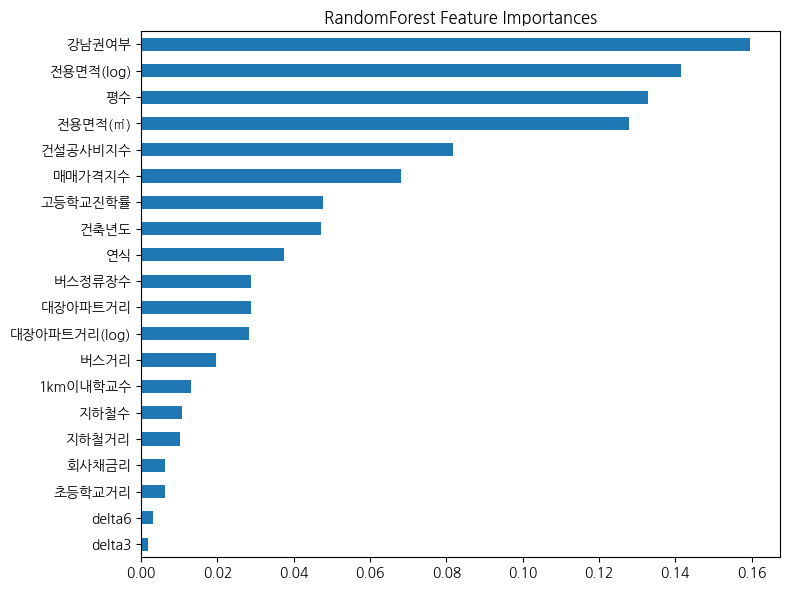

In [132]:
# 모델이 학습된 상태여야 합니다.
# rf.fit(X_train, y_train) 이 이미 호출된 후에 실행하세요.

# 피처 중요도 추출
rf_importances = rf.feature_importances_
rf_feat = pd.Series(rf_importances, index=X_train_df.columns).sort_values(ascending=False)

# 상위 20개 출력
print("RandomForest 하위 변수:\n", rf_feat.tail())

# 시각화
plt.figure(figsize=(8, 6))
rf_feat.head(20).plot(kind='barh')
plt.title("RandomForest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# 1. train, test 데이터 준비 (이미 준비된 DataFrame 가정)
# train: 학습용 데이터 (X_train, y_train 분리 필요)
# test: 테스트 데이터 (예측만 수행)

# # 2. 기본 모델 정의 (튜닝된 파라미터로 변경 가능)
# # RandomForestRegressor with overfitting control
# # rf = RandomForestRegressor(
# #     n_estimators=600,          # 트리 개수, 많을수록 안정
# #     max_depth=15,              # 트리 깊이 제한
# #     min_samples_leaf=4,        # 최소 잎노드 샘플 수
# #     min_samples_split=8,       # 내부 노드를 분할하는 최소 샘플 수
# #     max_features='sqrt',       # 최대 피처 샘플링 비율
# #     random_state=42,
# #     n_jobs=-1
# # )

# # LightGBM with regularization and early stopping
# # lgbm = LGBMRegressor(
# #     n_estimators=1000,
# #     max_depth=12,
# #     learning_rate=0.02,
# #     num_leaves=70,
# #     subsample=0.8,                 # 데이터 샘플링 비율
# #     subsample_freq=1,             # 샘플링 빈도
# #     colsample_bytree=0.8,         # 피처 샘플링 비율
# #     reg_alpha=0.2,                # L1 규제
# #     reg_lambda=0.3,               # L2 규제
# #     random_state=42,
# #     n_jobs=-1
# # )
# rf = RandomForestRegressor(
#     n_estimators=600,        # 트리 수 증가로 안정성 향상
#     max_depth=15,            # 깊이 조금 더 키움
#     min_samples_leaf=3,
#     min_samples_split=5,
#     max_features='sqrt',
#     random_state=42,
#     n_jobs=-1
# )

# lgbm = LGBMRegressor(
#     n_estimators=1500,       # 학습 횟수 증가
#     max_depth=12,
#     learning_rate=0.02,      # 학습률 감소로 안정성 증가
#     num_leaves=70,           # 잎사귀 수 증가
#     subsample=0.9,
#     subsample_freq=1,
#     colsample_bytree=0.85,
#     reg_alpha=0.25,
#     reg_lambda=0.4,
#     random_state=42,
#     n_jobs=-1
# )

# xgb = XGBRegressor(
#     n_estimators=1500,
#     max_depth=9,
#     learning_rate=0.02,
#     subsample=0.85,
#     colsample_bytree=0.85,
#     gamma=0.5,
#     reg_alpha=0.2,
#     reg_lambda=0.6,
#     random_state=42,
#     n_jobs=-1,
#     verbosity=0
# )

# # # XGBoost with regularization and early stopping
# # xgb = XGBRegressor(
# #     n_estimators=1500,
# #     max_depth=9,
# #     learning_rate=0.02,
# #     subsample=0.8,
# #     colsample_bytree=0.8,
# #     gamma=1,                     # 리프 노드 분할 최소 손실 감소량
# #     reg_alpha=0.15,              # L1 규제
# #     reg_lambda=0.5,              # L2 규제
# #     random_state=42,
# #     n_jobs=-1
# # )

# 6. 메타 피처 생성에 tqdm 추가
def create_meta_features(models, X, y, kf):
    n_samples = X.shape[0]
    n_models  = len(models)
    meta_features = np.zeros((n_samples, n_models))

    # 모델별 진행바
    for i, model in enumerate(tqdm(models, desc="Base models")):
        temp_pred = np.zeros(n_samples)
        # fold별 진행바
        for train_idx, val_idx in tqdm(kf.split(X), total=kf.get_n_splits(), desc=f"Model {i+1} folds", leave=False):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr = y[train_idx]
        # desc=f"Model {i+1} folds",
         # leave=False)
            y_tr = y[train_idx]
            if isinstance(model, LGBMRegressor):
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y[val_idx])],
                    eval_metric='rmse',
                    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
                )
            else:
                model.fit(X_tr, y_tr)
            temp_pred[val_idx] = model.predict(X_val)
        meta_features[:, i] = temp_pred

    return meta_features

# 7. 테스트 메타 피처 생성에 tqdm 추가
def get_test_meta_features(models, X_train, y_train, X_test):
    n_samples = X_test.shape[0]
    n_models  = len(models)
    meta_test_features = np.zeros((n_samples, n_models))

    # 모델별 진행바
    for i, model in enumerate(tqdm(models, desc="Retrain & Predict")):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        meta_test_features[:, i] = preds

    return meta_test_features

def objective(trial):
    # 기본 모델 하이퍼파라미터를 trial.suggest_... 로 동적으로 탐색
    rf_params = {
        'n_estimators': trial.suggest_int("rf_n_estimators", 300, 800),
        'max_depth': trial.suggest_int("rf_max_depth", 10, 30),
        'min_samples_leaf': trial.suggest_int("rf_min_samples_leaf", 1, 8),
        'min_samples_split': trial.suggest_int("rf_min_samples_split", 2, 10),
        'max_features': trial.suggest_categorical("rf_max_features", ["sqrt", "log2"]),
        'random_state': 42,
        'n_jobs': -1
    }
    lgbm_params = {
        'n_estimators': trial.suggest_int("lgbm_n_estimators", 800, 2000),
        'max_depth': trial.suggest_int("lgbm_max_depth", 8, 20),
        'learning_rate': trial.suggest_loguniform("lgbm_learning_rate", 0.005, 0.05),
        'num_leaves': trial.suggest_int("lgbm_num_leaves", 30, 100),
        'subsample': trial.suggest_uniform("lgbm_subsample", 0.7, 1.0),          
        'colsample_bytree': trial.suggest_uniform("lgbm_colsample_bytree", 0.7, 1.0),
        'reg_alpha': trial.suggest_loguniform("lgbm_reg_alpha", 1e-3, 1.0),
        'reg_lambda': trial.suggest_loguniform("lgbm_reg_lambda", 1e-3, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }
        
    xgb_params = {
        'n_estimators': trial.suggest_int("xgb_n_estimators", 800, 2000),
        'max_depth': trial.suggest_int("xgb_max_depth", 6, 12),
        'learning_rate': trial.suggest_loguniform("xgb_learning_rate", 0.005, 0.05),
        'subsample': trial.suggest_uniform("xgb_subsample", 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform("xgb_colsample_bytree", 0.7, 1.0),
        'gamma': trial.suggest_loguniform("xgb_gamma", 1e-3, 10),
        'reg_alpha': trial.suggest_loguniform("xgb_reg_alpha", 1e-3, 1.0),
        'reg_lambda': trial.suggest_loguniform("xgb_reg_lambda", 1e-3, 1.0),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    # 모델 생성에 하이퍼파라미터를 동적 적용
    rf_model = RandomForestRegressor(**rf_params)
    lgbm_model = LGBMRegressor(**lgbm_params)
    xgb_model = XGBRegressor(**xgb_params)
    models = [rf_model, lgbm_model, xgb_model]

    # 3. KFold 설정: 데이터셋을 5개 fold로 분할, 랜덤 셔플 후 고정 시드로 재현성 보장
    kf_inner = KFold(n_splits=5, shuffle=True, random_state=42)
    meta_X_train = create_meta_features(models, X_train, y_train, kf_inner)

    meta_model = Ridge(alpha=1.0, random_state=42)
    meta_model.fit(meta_X_train, y_train)
    train_preds = meta_model.predict(meta_X_train)
    rmse = mean_squared_error(y_train, train_preds, squared=False)
    return rmse

# 4. Optuna 스터디 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials= 30)

print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

# 5. 최적 하이퍼파라미터로 메타 피처 생성 및 최종 예측 (선택적)
best_params = study.best_params

# RF, LGBM, XGB 하이퍼파라미터 재구성
rf_best = RandomForestRegressor(
    n_estimators=best_params["rf_n_estimators"],
    max_depth=best_params["rf_max_depth"],
    min_samples_leaf=best_params["rf_min_samples_leaf"],
    min_samples_split=best_params["rf_min_samples_split"],
    max_features=best_params["rf_max_features"],
    random_state=42,
    n_jobs=-1
)
lgbm_best = LGBMRegressor(
    n_estimators=best_params["lgbm_n_estimators"],
    max_depth=best_params["lgbm_max_depth"],
    learning_rate=best_params["lgbm_learning_rate"],
    num_leaves=best_params["lgbm_num_leaves"],
    subsample=best_params["lgbm_subsample"],
    colsample_bytree=best_params["lgbm_colsample_bytree"],
    reg_alpha=best_params["lgbm_reg_alpha"],
    reg_lambda=best_params["lgbm_reg_lambda"],
    random_state=42,
    n_jobs=-1
)
xgb_best = XGBRegressor(
    n_estimators=best_params["xgb_n_estimators"],
    max_depth=best_params["xgb_max_depth"],
    learning_rate=best_params["xgb_learning_rate"],
    subsample=best_params["xgb_subsample"],
    colsample_bytree=best_params["xgb_colsample_bytree"],
    gamma=best_params["xgb_gamma"],
    reg_alpha=best_params["xgb_reg_alpha"],
    reg_lambda=best_params["xgb_reg_lambda"],
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
models_best = [rf_best, lgbm_best, xgb_best]

# meta_X_train_best = create_meta_features(models_best, X_train, y_train, kf_inner)
# meta_model = Ridge(alpha=1.0, random_state=42)
# meta_model.fit(meta_X_train_best, y_train)
# meta_X_test_best = get_test_meta_features(models_best, X_train, y_train, X_test)
# final_predictions = meta_model.predict(meta_X_test_best)

rmse_train = mean_squared_error(y_train, train_preds, squared=False)
print(f"학습 데이터 RMSE (원래 스케일): {rmse_train:.4f}")

# 메타 피처 생성 및 학습
meta_X_train_best = create_meta_features(models_best, X_train, y_train_log, kf_inner)
meta_model = Ridge(alpha=1.0, random_state=42)
meta_model.fit(meta_X_train_best, y_train_log)

# 테스트 데이터 예측 (로그 스케일)
meta_X_test_best = get_test_meta_features(models_best, X_train, y_train_log, X_test)
final_predictions_log = meta_model.predict(meta_X_test_best)

rounded_preds = np.round(final_predictions).astype(int)
submission = pd.DataFrame({'target': rounded_preds})
submission.to_csv('submission_optuna_3.csv', index=False)

print("submission.csv 파일이 생성되었습니다.")

# Trial 4 finished with value: 6976.950134385912 and parameters: 
# {'rf_n_estimators': 416, 'rf_max_depth': 29, 'rf_min_samples_leaf': 7, 'rf_min_samples_split': 10, 'rf_max_features': 'log2', 'lgbm_n_estimators': 1702, 'lgbm_max_depth': 12, 'lgbm_learning_rate': 0.03250541539651261, 'lgbm_num_leaves': 100, 'lgbm_subsample': 0.8825134881070337, 'lgbm_colsample_bytree': 0.7694061527956504, 'lgbm_reg_alpha': 0.0018934229948617048, 'lgbm_reg_lambda': 0.013487380991073253, 'xgb_n_estimators': 1859, 'xgb_max_depth': 11, 'xgb_learning_rate': 0.027347549729385235, 'xgb_subsample': 0.9874638592404601, 'xgb_colsample_bytree': 0.8254732898196115, 'xgb_gamma': 2.0678529807138832, 'xgb_reg_alpha': 0.9573441222792469, 'xgb_reg_lambda': 0.002039999771783618}.

[I 2025-09-10 05:30:30,358] A new study created in memory with name: no-name-4aaea52b-1b2d-4b14-a84f-a1e80e103473
Model 2 folds:   0%|                                                                                                                                      | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68673.084757



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:09<00:38,  9.55s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68675.229528



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:18<00:28,  9.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68589.420421



Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:28<00:18,  9.46s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68682.629430



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [00:37<00:09,  9.44s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68679.112651



Base models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:53<00:00, 117.69s/it]
[I 2025-09-10 05:36:23,483] Trial 0 finished with value: 7671.356726924271 and parameters: {'rf_n_estimators': 439, 'rf_max_depth': 22, 'rf_min_samples_leaf': 4, 'rf_min_samples_split': 4, 'rf_max_features': 'sqrt', 'lgbm_n_estimators': 870, 'lgbm_max_depth': 18, 'lgbm_learning_rate': 0.01508922761693878, 'lgbm_num_leaves': 80, 'lgbm_subsample': 0.8386528434982617, 'lgbm_colsample_bytree': 0.8066590135363939, 'lgbm_reg_alpha': 0.02597461697983109, 'lgbm_reg_lambda': 0.0014151951292920987, 'xgb_n_estimators': 1015, 'xgb_max_depth': 12, 'xgb_learning_rate': 0.012056019039957636, 'xgb_subsample': 0.706130373338387, 'xgb_colsample_bytree': 0.9899508916648752, 'xgb_gamma': 0.0804206172774185, 'xgb_reg_alpha': 0.0016693469893131411, 'xgb_reg_lambda': 0.006108885284025872}. Best is trial 0 with value: 7671.35672692427

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68673.084757



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:09<00:37,  9.45s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68675.229528



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:18<00:28,  9.50s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68589.420421



Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:28<00:19,  9.54s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68682.629430



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [00:38<00:09,  9.52s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68679.112651



Base models: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:30<00:00, 90.12s/it]
[I 2025-09-10 05:40:53,949] Trial 1 finished with value: 8404.959074654798 and parameters: {'rf_n_estimators': 413, 'rf_max_depth': 17, 'rf_min_samples_leaf': 4, 'rf_min_samples_split': 8, 'rf_max_features': 'sqrt', 'lgbm_n_estimators': 1267, 'lgbm_max_depth': 12, 'lgbm_learning_rate': 0.01604093780343286, 'lgbm_num_leaves': 37, 'lgbm_subsample': 0.9766687734358311, 'lgbm_colsample_bytree': 0.8754465388571177, 'lgbm_reg_alpha': 0.014771029135041663, 'lgbm_reg_lambda': 0.003581731989947876, 'xgb_n_estimators': 1675, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.01052853421711341, 'xgb_subsample': 0.9894830315714889, 'xgb_colsample_bytree': 0.9386757824151901, 'xgb_gamma': 0.23448250013190045, 'xgb_reg_alpha': 0.2934314196648967, 'xgb_reg_lambda': 0.014227986668123617}. Best is trial 0 with value: 7671.356726924271.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68673.084757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:17<01:11, 17.75s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68675.229528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:34<00:51, 17.22s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68589.420421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 


Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:51<00:34, 17.18s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68682.629430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [01:08<00:17, 17.07s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68679.112651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf



Base models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:54<00:00, 158.03s/it]
[I 2025-09-10 05:48:48,151] Trial 2 finished with value: 6997.674570392889 and parameters: {'rf_n_estimators': 455, 'rf_max_depth': 30, 'rf_min_samples_leaf': 3, 'rf_min_samples_split': 8, 'rf_max_features': 'sqrt', 'lgbm_n_estimators': 1855, 'lgbm_max_depth': 9, 'lgbm_learning_rate': 0.04242658540631049, 'lgbm_num_leaves': 91, 'lgbm_subsample': 0.7867698597036263, 'lgbm_colsample_bytree': 0.9318999378912337, 'lgbm_reg_alpha': 0.019420216343485473, 'lgbm_reg_lambda': 0.13534069475281635, 'xgb_n_estimators': 1611, 'xgb_max_depth': 12, 'xgb_learning_rate': 0.019195781111557137, 'xgb_subsample': 0.8962863880270682, 'xgb_colsample_bytree': 0.7210129457635254, 'xgb_gamma': 0.0015825891029491261, 'xgb_reg_alpha': 0.09116690285185983, 'xgb_reg_lambda': 0.021207475414872685}. Best is trial 2 with value: 6997.6745703928

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68673.084757



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:12<00:48, 12.25s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68675.229528



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:24<00:37, 12.34s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68589.420421



Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:37<00:24, 12.37s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68682.629430



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [00:49<00:12, 12.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68679.112651



Base models: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:42<00:00, 94.31s/it]
[I 2025-09-10 05:53:31,251] Trial 3 finished with value: 8021.764494490429 and parameters: {'rf_n_estimators': 435, 'rf_max_depth': 23, 'rf_min_samples_leaf': 2, 'rf_min_samples_split': 9, 'rf_max_features': 'sqrt', 'lgbm_n_estimators': 1216, 'lgbm_max_depth': 12, 'lgbm_learning_rate': 0.011344381572159504, 'lgbm_num_leaves': 70, 'lgbm_subsample': 0.9930610472765987, 'lgbm_colsample_bytree': 0.8655285065516036, 'lgbm_reg_alpha': 0.07649704232222218, 'lgbm_reg_lambda': 0.002104617149706288, 'xgb_n_estimators': 1768, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.04477978452865594, 'xgb_subsample': 0.75614809001778, 'xgb_colsample_bytree': 0.8863472152111841, 'xgb_gamma': 1.2941243561886735, 'xgb_reg_alpha': 0.19035343176275138, 'xgb_reg_lambda': 0.028536716205797976}. Best is trial 2 with value: 6997.674570392889.
M

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68673.084757



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:06<00:25,  6.49s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68675.229528



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:12<00:19,  6.37s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68589.420421



Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:19<00:12,  6.33s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68682.629430



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [00:25<00:06,  6.36s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68679.112651



Base models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:26<00:00, 128.80s/it]
[I 2025-09-10 05:59:57,832] Trial 4 finished with value: 7220.246061968156 and parameters: {'rf_n_estimators': 611, 'rf_max_depth': 12, 'rf_min_samples_leaf': 5, 'rf_min_samples_split': 10, 'rf_max_features': 'log2', 'lgbm_n_estimators': 892, 'lgbm_max_depth': 16, 'lgbm_learning_rate': 0.039402992504096755, 'lgbm_num_leaves': 35, 'lgbm_subsample': 0.9107924013168762, 'lgbm_colsample_bytree': 0.8393207073715483, 'lgbm_reg_alpha': 0.005000663358621135, 'lgbm_reg_lambda': 0.33255543677791505, 'xgb_n_estimators': 1621, 'xgb_max_depth': 12, 'xgb_learning_rate': 0.014255343581561773, 'xgb_subsample': 0.8688708166250598, 'xgb_colsample_bytree': 0.8125612507743386, 'xgb_gamma': 0.01633545522032646, 'xgb_reg_alpha': 0.008720172737919692, 'xgb_reg_lambda': 0.001933465017838867}. Best is trial 2 with value: 6997.674570392

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68673.084757



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:16<01:06, 16.59s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68675.229528



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:34<00:52, 17.36s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68589.420421



Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:52<00:35, 17.53s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68682.629430



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [01:10<00:17, 17.76s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68679.112651



Base models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:30<00:00, 110.05s/it]
[I 2025-09-10 06:05:28,042] Trial 5 finished with value: 7452.150926034207 and parameters: {'rf_n_estimators': 578, 'rf_max_depth': 19, 'rf_min_samples_leaf': 8, 'rf_min_samples_split': 5, 'rf_max_features': 'sqrt', 'lgbm_n_estimators': 1695, 'lgbm_max_depth': 18, 'lgbm_learning_rate': 0.03600226417064865, 'lgbm_num_leaves': 95, 'lgbm_subsample': 0.8896643086725092, 'lgbm_colsample_bytree': 0.9959042127661304, 'lgbm_reg_alpha': 0.06430984507279675, 'lgbm_reg_lambda': 0.11619985702894159, 'xgb_n_estimators': 1527, 'xgb_max_depth': 6, 'xgb_learning_rate': 0.007230391559069124, 'xgb_subsample': 0.9970759930303383, 'xgb_colsample_bytree': 0.8982583085304771, 'xgb_gamma': 0.0027741805106208345, 'xgb_reg_alpha': 0.01806405005599721, 'xgb_reg_lambda': 0.17352239098307334}. Best is trial 2 with value: 6997.674570392889

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68673.084757



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:13<00:53, 13.37s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68675.229528



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:26<00:40, 13.37s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68589.420421



Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:40<00:26, 13.42s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68682.629430



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [00:53<00:13, 13.39s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68679.112651



Base models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:44<00:00, 114.94s/it]
[I 2025-09-10 06:11:12,900] Trial 6 finished with value: 7988.811725770286 and parameters: {'rf_n_estimators': 784, 'rf_max_depth': 12, 'rf_min_samples_leaf': 2, 'rf_min_samples_split': 6, 'rf_max_features': 'log2', 'lgbm_n_estimators': 1428, 'lgbm_max_depth': 11, 'lgbm_learning_rate': 0.027064600004342056, 'lgbm_num_leaves': 82, 'lgbm_subsample': 0.9643365154324792, 'lgbm_colsample_bytree': 0.8747506631348482, 'lgbm_reg_alpha': 0.6545432771502393, 'lgbm_reg_lambda': 0.0034993883775641843, 'xgb_n_estimators': 1249, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.010282106931476433, 'xgb_subsample': 0.948612921579966, 'xgb_colsample_bytree': 0.8121373474857314, 'xgb_gamma': 0.9866970330248183, 'xgb_reg_alpha': 0.05264264534540749, 'xgb_reg_lambda': 0.08589268878527587}. Best is trial 2 with value: 6997.674570392889.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003712 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68673.084757



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:14<00:57, 14.48s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68675.229528



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:28<00:41, 14.00s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68589.420421



Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:41<00:27, 13.82s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68682.629430



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [00:55<00:13, 13.74s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68679.112651



Base models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [06:21<00:00, 127.04s/it]
[I 2025-09-10 06:17:34,083] Trial 7 finished with value: 7100.652087008652 and parameters: {'rf_n_estimators': 517, 'rf_max_depth': 23, 'rf_min_samples_leaf': 8, 'rf_min_samples_split': 6, 'rf_max_features': 'log2', 'lgbm_n_estimators': 1835, 'lgbm_max_depth': 19, 'lgbm_learning_rate': 0.047328904667502, 'lgbm_num_leaves': 52, 'lgbm_subsample': 0.864408411579974, 'lgbm_colsample_bytree': 0.9131724160229813, 'lgbm_reg_alpha': 0.5034584649726582, 'lgbm_reg_lambda': 0.6365606405751175, 'xgb_n_estimators': 1267, 'xgb_max_depth': 11, 'xgb_learning_rate': 0.02695274134522273, 'xgb_subsample': 0.8018671875796505, 'xgb_colsample_bytree': 0.8577912796974524, 'xgb_gamma': 3.239834846438071, 'xgb_reg_alpha': 0.005786777816348559, 'xgb_reg_lambda': 0.0013424562024809078}. Best is trial 2 with value: 6997.674570392889.
Mode

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68673.084757



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:12<00:48, 12.15s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68675.229528



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:24<00:36, 12.10s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68589.420421



Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:36<00:24, 12.12s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68682.629430



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [00:48<00:12, 12.07s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68679.112651



Base models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:47<00:00, 115.73s/it]
[I 2025-09-10 06:23:21,450] Trial 8 finished with value: 7351.845333125864 and parameters: {'rf_n_estimators': 551, 'rf_max_depth': 23, 'rf_min_samples_leaf': 4, 'rf_min_samples_split': 4, 'rf_max_features': 'log2', 'lgbm_n_estimators': 1120, 'lgbm_max_depth': 20, 'lgbm_learning_rate': 0.012864839049526266, 'lgbm_num_leaves': 79, 'lgbm_subsample': 0.8501168179736418, 'lgbm_colsample_bytree': 0.8307419968424867, 'lgbm_reg_alpha': 0.11340838353190849, 'lgbm_reg_lambda': 0.18061164246298073, 'xgb_n_estimators': 1788, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.030639034574301408, 'xgb_subsample': 0.8834505288112685, 'xgb_colsample_bytree': 0.7074313527871058, 'xgb_gamma': 0.040060365648101656, 'xgb_reg_alpha': 0.003925110463921339, 'xgb_reg_lambda': 0.0768921917710027}. Best is trial 2 with value: 6997.674570392889

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2745
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68673.084757



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:08<00:34,  8.55s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 24
[LightGBM] [Info] Start training from score 68675.229528



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:16<00:24,  8.31s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68589.420421



Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:24<00:16,  8.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68682.629430



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [00:33<00:08,  8.29s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2748
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 24
[LightGBM] [Info] Start training from score 68679.112651



Base models: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [05:22<00:00, 107.37s/it]
[I 2025-09-10 06:28:43,608] Trial 9 finished with value: 8390.492589074243 and parameters: {'rf_n_estimators': 778, 'rf_max_depth': 14, 'rf_min_samples_leaf': 5, 'rf_min_samples_split': 9, 'rf_max_features': 'sqrt', 'lgbm_n_estimators': 951, 'lgbm_max_depth': 18, 'lgbm_learning_rate': 0.04614942328183108, 'lgbm_num_leaves': 67, 'lgbm_subsample': 0.7373824936746135, 'lgbm_colsample_bytree': 0.7290157038413482, 'lgbm_reg_alpha': 0.0050490413334705105, 'lgbm_reg_lambda': 0.13533449269864312, 'xgb_n_estimators': 1271, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.02390979244219748, 'xgb_subsample': 0.7875814595831765, 'xgb_colsample_bytree': 0.8833214385477384, 'xgb_gamma': 4.825129949348402, 'xgb_reg_alpha': 0.08021739050359561, 'xgb_reg_lambda': 0.0814157092299884}. Best is trial 2 with value: 6997.674570392889.
Mod

In [13]:
rf_best = RandomForestRegressor(
    n_estimators=416,
    max_depth=29,
    min_samples_leaf=7,
    min_samples_split=10,
    max_features='log2',
    random_state=42,
    n_jobs=-1
)

lgbm_best = LGBMRegressor(
    n_estimators=1702,
    max_depth=12,
    learning_rate=0.03250541539651261,
    num_leaves=100,
    subsample=0.8825134881070337,
    colsample_bytree=0.7694061527956504,
    reg_alpha=0.0018934229948617048,
    reg_lambda=0.013487380991073253,
    random_state=42,
    n_jobs=-1
)

xgb_best = XGBRegressor(
    n_estimators=1859,
    max_depth=11,
    learning_rate=0.027347549729385235,
    subsample=0.9874638592404601,
    colsample_bytree=0.8254732898196115,
    gamma=2.0678529807138832,
    reg_alpha=0.9573441222792469,
    reg_lambda=0.002039999771783618,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

models_best = [rf_best, lgbm_best, xgb_best]

kf_inner = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. 메타 피처 생성 (train셋에 대해서)
meta_X_train_best = create_meta_features(models_best, X_train, y_train_log, kf_inner)

# 4. 메타 모델 학습 (Ridge 등 사용)
from sklearn.linear_model import Ridge
meta_model = Ridge(alpha=1.0, random_state=42)
meta_model.fit(meta_X_train_best, y_train_log)

# 5. 테스트 데이터 메타 피처 생성
meta_X_test_best = get_test_meta_features(models_best, X_train, y_train_log, X_test)

# 6. 테스트 예측 (로그 스케일)
final_predictions_log = meta_model.predict(meta_X_test_best)

# 7. 로그 역변환 및 제출용 반올림
import numpy as np
final_predictions = np.exp(final_predictions_log)
rounded_preds = np.round(final_predictions).astype(int)

# 8. 제출 파일 생성
import pandas as pd
submission = pd.DataFrame({'target': rounded_preds})
submission.to_csv('submission_optuna_2.csv', index=False)

print("submission_optuna_2.csv 파일이 생성되었습니다.")

Model 2 folds:   0%|                                                                                                                                      | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3255
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 26
[LightGBM] [Info] Start training from score 10.929048



Model 2 folds:  20%|█████████████████████████▏                                                                                                    | 1/5 [00:18<01:14, 18.54s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3258
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 26
[LightGBM] [Info] Start training from score 10.928988



Model 2 folds:  40%|██████████████████████████████████████████████████▍                                                                           | 2/5 [00:37<00:55, 18.56s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3258
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 26
[LightGBM] [Info] Start training from score 10.928201



Model 2 folds:  60%|███████████████████████████████████████████████████████████████████████████▌                                                  | 3/5 [00:55<00:37, 18.55s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3258
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 26
[LightGBM] [Info] Start training from score 10.928739



Model 2 folds:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4/5 [01:14<00:18, 18.58s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3258
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 26
[LightGBM] [Info] Start training from score 10.929101



Retrain & Predict:  33%|████████████████████████████████████████▋                                                                                 | 1/3 [00:41<01:22, 41.24s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3258
[LightGBM] [Info] Number of data points in the train set: 635467, number of used features: 26
[LightGBM] [Info] Start training from score 10.928815


Retrain & Predict: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:08<00:00, 22.82s/it]

submission_optuna_2.csv 파일이 생성되었습니다.


In [16]:

# 메타 모델 학습 완료 후 train 예측값 생성
train_preds_log = meta_model.predict(meta_X_train_best)

# 로그 스케일에서 역변환
train_preds = np.expm1(train_preds_log)  # np.expm1는 exp(x)-1 함수

# 실제 타겟 원본 스케일 (y_train)과 비교해 RMSE 계산
rmse_train = mean_squared_error(y_train, train_preds, squared=False)

print(f"Train RMSE (원본 스케일): {rmse_train:.4f}")

Train RMSE (원본 스케일): 7599.7428


In [21]:
# 베스트 하이퍼파라미터로 모델 생성
rf_best = RandomForestRegressor(
    n_estimators=527,
    max_depth=11,
    min_samples_leaf=8,
    min_samples_split=9,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

lgbm_best = LGBMRegressor(
    n_estimators=801,
    max_depth=12,
    learning_rate=0.04106361615104415,
    num_leaves=92,
    # subsample 필드는 탐색 안 해서 기본값 1.0 유지
    subsample=1.0,
    colsample_bytree=1.0,  # Optuna 결과에 없으면 기본값 사용
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1
)

xgb_best = XGBRegressor(
    n_estimators=1880,
    max_depth=11,
    learning_rate=0.03714747220843659,
    subsample=0.9262954478976996,
    colsample_bytree=0.7112897029011118,
    gamma=0.7723753348363707,
    reg_alpha=0.12643220684416703,
    reg_lambda=0.942169270895758,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

models_best = [rf_best, lgbm_best, xgb_best]

# KFold 정의 (필요 시)
kf_inner = KFold(n_splits=5, shuffle=True, random_state=42)

# 1. 로그 변환된 타깃
y_train_log = np.log1p(y_train)

# 2. 메타 피처 생성 및 메타 모델 학습
meta_X_train_best = create_meta_features(models_best, X_train, y_train_log, kf_inner)
meta_model = Ridge(alpha=1.0, random_state=42)
meta_model.fit(meta_X_train_best, y_train_log)

# 3. 학습 데이터에 대한 로그 스케일 예측
train_preds_log = meta_model.predict(meta_X_train_best)

# 4. 역변환(원래 스케일)
train_preds = np.expm1(train_preds_log)

# 5. 원래 스케일의 실제값과 예측값으로 RMSE 계산
rmse_train = mean_squared_error(y_train, train_preds, squared=False)
print(f"학습 데이터 RMSE (원래 스케일): {rmse_train:.4f}")

# 6. 테스트 데이터 메타 피처 생성 및 예측
meta_X_test_best = get_test_meta_features(models_best, X_train, y_train_log, X_test)
final_predictions_log = meta_model.predict(meta_X_test_best)

# 7. 역변환 후 제출용 예측값 생성
final_predictions = np.expm1(final_predictions_log)

# 필요시 반올림 등 후처리 해 제출 파일 생성
# 8. 반올림 및 CSV 파일 생성 (필요 시)
rounded_preds = np.round(final_predictions).astype(int)
submission = pd.DataFrame({'target': rounded_preds})
submission.to_csv('submission_optuna_log.csv', index=False)

print("submission.csv 파일이 생성되었습니다.")

Model 2 folds:   0%|                                                                                        | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2382
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 18
[LightGBM] [Info] Start training from score 10.929048



Model 2 folds:  20%|████████████████                                                                | 1/5 [00:07<00:30,  7.63s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 508373, number of used features: 18
[LightGBM] [Info] Start training from score 10.928988



Model 2 folds:  40%|████████████████████████████████                                                | 2/5 [00:15<00:22,  7.66s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 18
[LightGBM] [Info] Start training from score 10.928201



Model 2 folds:  60%|████████████████████████████████████████████████                                | 3/5 [00:23<00:15,  7.74s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 18
[LightGBM] [Info] Start training from score 10.928739



Model 2 folds:  80%|████████████████████████████████████████████████████████████████                | 4/5 [00:31<00:07,  7.81s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 508374, number of used features: 18
[LightGBM] [Info] Start training from score 10.929101



Base models: 100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [03:12<00:00, 64.03s/it]


학습 데이터 RMSE (원래 스케일): 8778.0485


Retrain & Predict:  33%|█████████████████████████▎                                                  | 1/3 [00:31<01:03, 31.78s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 635467, number of used features: 18
[LightGBM] [Info] Start training from score 10.928815


Retrain & Predict: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [00:45<00:00, 15.24s/it]

submission.csv 파일이 생성되었습니다.


In [ ]:
# 1. Count Encoding (데이터 전처리)
# for col in ['구', '아파트명']:
#     if col in X_train.columns:  # 컬럼 존재 확인
#         freq_map = X_train[col].value_counts().to_dict()
#         X_train[col + '_count'] = X_train[col].map(freq_map)
#         X_test[col + '_count'] = X_test[col].map(freq_map).fillna(0)
        
#         # 원본 범주형 컬럼 제거
#         X_train = X_train.drop(columns=[col])
#         X_test = X_test.drop(columns=[col])


# # 2. 타겟 이상치 클리핑 함수 및 적용
# def clip_outliers(arr):
#     q1 = np.quantile(arr, 0.25)
#     q3 = np.quantile(arr, 0.75)
#     iqr = q3 - q1
#     lower = q1 - 1.5 * iqr
#     upper = q3 + 1.5 * iqr
#     return np.clip(arr, lower, upper)

# y_train = clip_outliers(y_train)

# # 3. 계약년월 기준 정렬
# X_train = X_train.sort_values('계약년월')
# y_train = y_train[X_train.index]

# 4. 로그 변환
y_train_log = np.log1p(y_train)

# 5. 메타 피처 생성 함수 정의
def create_meta_features(models, X, y, kf):
    n_samples = len(X)
    n_models = len(models)
    meta_features = np.zeros((n_samples, n_models), dtype=float)
    
    for i, model in enumerate(tqdm(models, desc="Base models")):
        temp_pred = np.zeros(n_samples)
        for train_idx, val_idx in tqdm(kf.split(X), total=kf.get_n_splits(), desc=f"Model {i+1} folds", leave=False):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr = y[train_idx]
            
            if isinstance(model, LGBMRegressor):
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y[val_idx])],
                    eval_metric='rmse',
                    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
                )
            else:
                model.fit(X_tr, y_tr)
            
            temp_pred[val_idx] = model.predict(X_val)
        meta_features[:, i] = temp_pred
    return meta_features

# 6. 테스트 메타 피처 생성 함수 정의
def get_test_meta_features(models, X_train, y_train, X_test):
    n_samples = X_test.shape[0]
    n_models = len(models)
    meta_test_features = np.zeros((n_samples, n_models), dtype=float)
    
    for i, model in enumerate(tqdm(models, desc="Retrain & Predict")):
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        meta_test_features[:, i] = preds
    return meta_test_features

# 7. Optuna objective 함수 정의
def objective(trial):
    # 하이퍼파라미터 탐색 범위
    # rf_params = {
    #     'n_estimators': trial.suggest_int("rf_n_estimators", 300, 800),
    #     'max_depth': trial.suggest_int("rf_max_depth", 10, 40),
    #     'min_samples_leaf': trial.suggest_int("rf_min_samples_leaf", 1, 8),
    #     'min_samples_split': trial.suggest_int("rf_min_samples_split", 2, 20),
    #     'max_features': trial.suggest_categorical("rf_max_features", ["sqrt", "log2", None]),
    #     'random_state': 42,
    #     'n_jobs': -1
    # }
    
    lgbm_params = {
        'n_estimators': trial.suggest_int("lgbm_n_estimators", 800, 3000),
        'max_depth': trial.suggest_int("lgbm_max_depth", 8, 25),
        'learning_rate': trial.suggest_loguniform("lgbm_learning_rate", 0.001, 0.1),
        'num_leaves': trial.suggest_int("lgbm_num_leaves", 30, 150),
        'subsample': trial.suggest_uniform("lgbm_subsample", 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform("lgbm_colsample_bytree", 0.7, 1.0),
        'reg_alpha': trial.suggest_loguniform("lgbm_reg_alpha", 1e-5, 1.0),
        'reg_lambda': trial.suggest_loguniform("lgbm_reg_lambda", 1e-5, 1.0),
        'random_state': 42,
        'n_jobs': -1
    }
    
    xgb_params = {
        'n_estimators': trial.suggest_int("xgb_n_estimators", 800, 3000),
        'max_depth': trial.suggest_int("xgb_max_depth", 4, 15),
        'learning_rate': trial.suggest_loguniform("xgb_learning_rate", 0.001, 0.1),
        'subsample': trial.suggest_uniform("xgb_subsample", 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform("xgb_colsample_bytree", 0.7, 1.0),
        'gamma': trial.suggest_loguniform("xgb_gamma", 1e-5, 50),
        'reg_alpha': trial.suggest_loguniform("xgb_reg_alpha", 1e-5, 1.0),
        'reg_lambda': trial.suggest_loguniform("xgb_reg_lambda", 1e-5, 1.0),
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    # 모델 생성
    # rf_model = RandomForestRegressor(**rf_params)
    lgbm_model = LGBMRegressor(**lgbm_params)
    xgb_model = XGBRegressor(**xgb_params)
    models = [ lgbm_model, xgb_model]
    # rf_model,
    # TimeSeriesSplit 사용
    tscv = TimeSeriesSplit(n_splits=5)
    meta_X_train = create_meta_features(models, X_train, y_train_log, tscv)
    
    # 메타 모델 학습 및 평가
    meta_model_ridge = Ridge(alpha=1.0, random_state=42)
    meta_model_ridge.fit(meta_X_train, y_train_log)
    train_preds_log = meta_model_ridge.predict(meta_X_train)
    train_preds = np.expm1(train_preds_log)  # 로그 역변환
    rmse = mean_squared_error(y_train, train_preds, squared=False)
    return rmse

# 8. Optuna 스터디 실행
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
print("Best RMSE:", study.best_value)
print("Best params:", study.best_params)

# 9. 최적 하이퍼파라미터 추출 및 모델 생성
best_params = study.best_params

# rf_best = RandomForestRegressor(
#     n_estimators=best_params["rf_n_estimators"],
#     max_depth=best_params["rf_max_depth"],
#     min_samples_leaf=best_params["rf_min_samples_leaf"],
#     min_samples_split=best_params["rf_min_samples_split"],
#     max_features=best_params["rf_max_features"],
#     random_state=42,
#     n_jobs=-1
# )

lgbm_best = LGBMRegressor(
    n_estimators=best_params["lgbm_n_estimators"],
    max_depth=best_params["lgbm_max_depth"],
    learning_rate=best_params["lgbm_learning_rate"],
    num_leaves=best_params["lgbm_num_leaves"],
    subsample=best_params["lgbm_subsample"],
    colsample_bytree=best_params["lgbm_colsample_bytree"],
    reg_alpha=best_params["lgbm_reg_alpha"],
    reg_lambda=best_params["lgbm_reg_lambda"],
    random_state=42,
    n_jobs=-1
)

xgb_best = XGBRegressor(
    n_estimators=best_params["xgb_n_estimators"],
    max_depth=best_params["xgb_max_depth"],
    learning_rate=best_params["xgb_learning_rate"],
    subsample=best_params["xgb_subsample"],
    colsample_bytree=best_params["xgb_colsample_bytree"],
    gamma=best_params["xgb_gamma"],
    reg_alpha=best_params["xgb_reg_alpha"],
    reg_lambda=best_params["xgb_reg_lambda"],
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

models_best = [ lgbm_best, xgb_best]
# rf_best,
# 10. TimeSeriesSplit 정의
tscv = TimeSeriesSplit(n_splits=5)

# 11. 메타 피처 생성 및 메타 모델 학습
meta_X_train_best = create_meta_features(models_best, X_train, y_train_log, tscv)

# 12. 메타 모델 학습 (Ridge와 LGBM 둘 다)
meta_model_ridge = Ridge(alpha=1.0, random_state=42)
meta_model_lgbm = LGBMRegressor(n_estimators=200, random_state=42)

meta_model_ridge.fit(meta_X_train_best, y_train_log)
meta_model_lgbm.fit(meta_X_train_best, y_train_log)

# 13. 훈련 성능 평가
train_preds_ridge_log = meta_model_ridge.predict(meta_X_train_best)
train_preds_ridge = np.expm1(train_preds_ridge_log)
rmse_train_ridge = mean_squared_error(y_train, train_preds_ridge, squared=False)
print(f"Ridge 메타모델 Train RMSE (원래 스케일): {rmse_train_ridge:.4f}")

train_preds_lgbm_log = meta_model_lgbm.predict(meta_X_train_best)
train_preds_lgbm = np.expm1(train_preds_lgbm_log)
rmse_train_lgbm = mean_squared_error(y_train, train_preds_lgbm, squared=False)
print(f"LGBM 메타모델 Train RMSE (원래 스케일): {rmse_train_lgbm:.4f}")

# 14. 테스트 데이터 예측
meta_X_test_best = get_test_meta_features(models_best, X_train, y_train_log, X_test)

# Ridge 예측
final_predictions_log_ridge = meta_model_ridge.predict(meta_X_test_best)
final_predictions_ridge = np.expm1(final_predictions_log_ridge)  # 로그 역변환
rounded_preds_ridge = np.round(final_predictions_ridge).astype(int)

# LGBM 예측
final_predictions_log_lgbm = meta_model_lgbm.predict(meta_X_test_best)
final_predictions_lgbm = np.expm1(final_predictions_log_lgbm)  # 로그 역변환
rounded_preds_lgbm = np.round(final_predictions_lgbm).astype(int)

# 15. 제출파일 저장
submission_ridge = pd.DataFrame({'target': rounded_preds_ridge})
submission_ridge.to_csv('submission_optuna_ridge2.csv', index=False)
print("submission_optuna_ridge.csv 파일이 생성되었습니다.")

submission_lgbm = pd.DataFrame({'target': rounded_preds_lgbm})
submission_lgbm.to_csv('submission_optuna_lgbm2.csv', index=False)
print("submission_optuna_lgbm.csv 파일이 생성되었습니다.")


In [11]:
# meta_model = Ridge(alpha=1.0, random_state=42) # 메타 모델 생성
# meta_model.fit(meta_X_train, y_train)
# meta_X_train = create_meta_features(models, X_train, y_train, kf)
# meta_X_test = get_test_meta_features(models, X_train, y_train, X_test)
# final_predictions = meta_model.predict(meta_X_test)

# # 메타 모델 훈련 데이터 예측
# meta_train_preds = meta_model.predict(meta_X_train)

# RMSE 계산
# rmse_meta_train = mean_squared_error(y_train, meta_train_preds, squared=False)
# print(f"메타 모델 학습 RMSE: {rmse_meta_train:.4f}")

# # 테스트 데이터 예측
# meta_X_test = get_test_meta_features(models, X_train, y_train, X_test)
# final_predictions = meta_model.predict(meta_X_test)

메타 모델 학습 RMSE: 7584.4036


Retrain & Predict:  33%|█████████████████████████▎                                                  | 1/3 [00:47<01:35, 47.70s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2385
[LightGBM] [Info] Number of data points in the train set: 635467, number of used features: 18
[LightGBM] [Info] Start training from score 68659.895346


Retrain & Predict: 100%|████████████████████████████████████████████████████████████████████████████| 3/3 [01:15<00:00, 25.02s/it]


In [72]:
def stacking_cv_rmse(models, meta_models, X, y, kf):
    rmses = []
    for train_idx, val_idx in kf.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # 베이스 모델 OOF 메타 피처
        meta_tr = create_meta_features_advanced(models, X_tr, y_tr, kf)
        meta_val = np.column_stack([
            m.fit(X_tr, y_tr).predict(X_val) for m in models
        ])

        # 메타 모델 예측값 평균
        final_val_pred = np.zeros(len(y_val))
        for meta_model in meta_models.values():
            meta_model.fit(meta_tr, y_tr)
            final_val_pred += meta_model.predict(meta_val) * (1/len(meta_models))
        
        rmses.append(mean_squared_error(y_val, final_val_pred, squared=False))

    return np.mean(rmses), np.std(rmses)

mean_rmse, std_rmse = stacking_cv_rmse(models, meta_predictions, X_train, y_train, kf)
print(f"스태킹 앙상블 CV RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")


메타 모델 학습 RMSE: 10780.4784


In [ ]:
rounded_final_predictions = np.round(final_predictions)
submission = pd.DataFrame({
    'target': final_predictions
})
submission.to_csv('submission_5ensemble_imeanse.csv', index=False)